In [1]:
import pandas as pd
import numpy as np

# load CDR
fname = 'cdr.csv'
df = pd.read_csv(fname, index_col=0)
df.index = pd.to_datetime(df.index)

display(df.tail(5))
print()
print('Total:%d probek od:%s do:%s' %(len(df), df.index[0].date(), df.index[-1].date()))
print('%s kolumn:%s' %(len(df.columns), list(df.columns)))

,open,high,low,close,vol,avg_temp_leba,short_size
Data,,,,,,,
2021-02-01,305.5,316.0,291.3,305.8,1008657.0,-7.4,0.79
2021-02-02,305.5,305.9,282.4,283.3,1379193.0,-1.2,0.79
2021-02-03,284.0,295.6,283.4,288.0,690037.0,2.4,0.79
2021-02-04,288.1,298.8,288.1,291.0,403339.0,0.7,0.79
2021-02-05,293.2,297.9,288.2,293.4,434366.0,0.7,0.65



Total:2017 probek od:2013-01-04 do:2021-02-05
7 kolumn:['open', 'high', 'low', 'close', 'vol', 'avg_temp_leba', 'short_size']


In [2]:
import seaborn as sns

# calculate the correlation matrix
corr = df.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot = True)

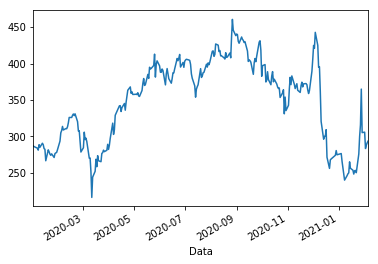

In [3]:
df['close'][df.index>'2020-01-01'].plot()

In [4]:
# convert to stationary
df_pct = df.pct_change().fillna(0)

#wyzerowanie infinite vals (gdy poprzednia byla 0)
for col in df_pct:
    df_pct.loc[abs(df_pct[col]) == np.inf, col] = 0

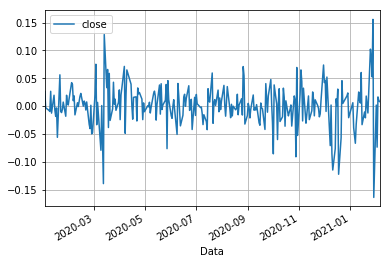

In [5]:
df_pct['close'][df.index>'2020-01-01'].plot(grid=True, legend=True)

In [6]:
y = df['close'].pct_change().shift(periods=-1).fillna(0)

In [7]:
test_beg = '2020-12-31'

# podzial train/test (bez pierwszego wiersza)
train_mask = (df.index<test_beg) & (df.index>df.index[0])
test_mask = df.index>=test_beg

cols = list(df_pct.columns)

x_train = df_pct[cols][train_mask].astype(float)
x_test = df_pct[cols][test_mask].astype(float)

y_train = y[train_mask].astype(float)
y_test = y[test_mask].astype(float)

assert(len(x_train)==len(y_train))
assert(len(x_test)==len(y_test))

In [8]:
from sklearn.preprocessing import StandardScaler

scaler_df = StandardScaler() 

#budujuemy scaler na danych TRAIN only
scaler_df.fit_transform(x_train)

#aplikujemy skaler na dane
x_train = scaler_df.transform(x_train)
x_test = scaler_df.transform(x_test)

In [9]:
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train, random_state=0)

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

def my_model(feat):
    
    x_input = Input(shape = (feat,))
    x = Dense(20, name='hidden')(x_input)
    x_output = Dense(1, activation='linear', name='out')(x)

    model = Model(inputs = x_input, outputs = x_output, name='way2becomefcknrich')
    
    return model

#num features
feat = np.shape(x_train)[1]

model = my_model(feat)
model.compile(loss='mean_squared_error')
model.summary()

Model: "way2becomefcknrich"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
hidden (Dense)               (None, 20)                160       
_________________________________________________________________
out (Dense)                  (None, 1)                 21        
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.fit(x_train, y_train, epochs=20)

Epoch 1/20
63/63 [==============================] - 1s 3ms/step - loss: 0.2995
Epoch 2/20
63/63 [==============================] - 0s 4ms/step - loss: 0.0476
Epoch 3/20
63/63 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 4/20
63/63 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 5/20
63/63 [==============================] - 0s 4ms/step - loss: 9.7570e-04
Epoch 6/20
63/63 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 7/20
63/63 [==============================] - 0s 4ms/step - loss: 9.1466e-04
Epoch 8/20
63/63 [==============================] - 0s 4ms/step - loss: 9.6367e-04
Epoch 9/20
63/63 [==============================] - 0s 3ms/step - loss: 9.6355e-04
Epoch 10/20
63/63 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 11/20
63/63 [==============================] - 0s 3ms/step - loss: 9.4177e-04
Epoch 12/20
63/63 [==============================] - 0s 3ms/step - loss: 8.7331e-04
Epoch 13/20
63/63 [======

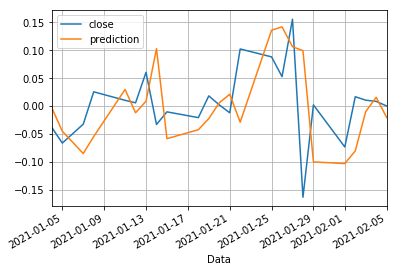

In [12]:
y_predicted = model.predict(x_test)

df_pred = pd.concat([y_test, pd.DataFrame(y_predicted, index=y_test.index, columns=['prediction'])], axis=1)
df_pred.plot(grid=True)

In [13]:
mask = np.sign(df_pred['close']) == np.sign(df_pred['prediction'])
acc = np.sum(mask) / len(df_pred)
display(acc)

0.5416666666666666

In [14]:
trans_positive = df_pred['close'][mask].abs()
trans_loss = df_pred['close'][~mask].abs()

print('accuracy:%.2f%% trans_positive:%.2f%% trans_loss:%.2f%%' %(100*acc, 100*trans_positive.sum(), 100*trans_loss.sum()))

accuracy:54.17% trans_positive:62.04% trans_loss:38.98%


In [15]:
cost_per_tran = 2 * 0.0038
len(df_pred) * cost_per_tran

0.1824